# Import Packages

In [205]:
import os
import math
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import cvxpy as cp

from scipy.stats import spearmanr
from IPython.core.display import display, HTML
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from scipy.optimize import minimize
from matplotlib.backends.backend_svg import FigureCanvasSVG

from prep_factor import PrepFactor
from functions.utils.system import *
from functions.utils.func import *

import warnings

warnings.filterwarnings('ignore')

# Functions

In [206]:
#Reads in all the results in the "modelName" folder
def read_result(model_name, result_name):
    data = []
    result_data_dir = get_result_model(live, model_name)
    for i, folder_name in enumerate(os.listdir(result_data_dir)):
        try:
            if folder_name.startswith("params"):
                folder_path = os.path.join(result_data_dir, folder_name)
                file_path = os.path.join(folder_path, f"{result_name}.parquet.brotli")
                print(os.path.basename(folder_path))
                data.append(pd.read_parquet(file_path))
        except:
            continue
    return pd.concat(data, axis=0).reset_index(drop=True)

#Calculates the product of the daily_ic_mean and maximum overall IC in each result to find the best performing model
def get_max_ic(data):
    collection={}
    for index, row in data.iterrows():
        collection[max(row.loc[(row.index.str.startswith("dIC"))])]=index
    max_ic_idx=collection[max(list(collection.keys()))]
    return data.iloc[max_ic_idx]

#Gets the files of the best performing model
def get_max_ic_file(data, model_name):
    files = {}
    time_index = data.to_frame().index.get_loc('time')
    param_vals = data.iloc[:time_index].values
    key = [f'{float(p)}' for p in (param_vals)]
    key = '_'.join(key)
    
    result_data_dir = get_result_model(live, model_name) / f'params_{key}'
    for file in os.listdir(result_data_dir):
        if file.endswith(".parquet.brotli"):
            files[extract_first_string(file)]=pd.read_parquet(os.path.join(result_data_dir, file))
        elif file.endswith(".png"):
            img = os.path.join(result_data_dir, file)
            files[extract_first_string(file)]=Image(img)
    return files

def get_all(model_name):
    return get_max_ic_file(get_max_ic(read_result(model_name, 'metrics')), model_name)

def sign_accuracy(predictions, actual, target_sign, pred):
    accuracies = []  # To store accuracies for each ticker
    
    # Iterate through each ticker and calculate accuracy
    for ticker in predictions.index.levels[0]:
        ticker_group = predictions.loc[ticker]
        actual_group = actual.loc[ticker]
        
        # Determine if each pair has the same sign
        if pred == 'price':
            correct_signs = (np.sign(ticker_group) == np.sign(actual_group))
        elif pred == 'sign':
            correct_signs = (ticker_group == np.sign(actual_group))
            
        # Filter by target sign if specified
        if target_sign == 'positive':
            mask = (np.sign(actual_group) == 1)
            correct_signs = correct_signs[mask]
        elif target_sign == 'negative':
            mask = (np.sign(actual_group) == -1)
            correct_signs = correct_signs[mask]
        
        # Calculate the accuracy and store it
        accuracy = np.mean(correct_signs) * 100  # Convert to percentage
        accuracies.append(accuracy)
        
    # Calculate and return the mean accuracy across all tickers
    mean_accuracy = np.nanmean(accuracies)
    return mean_accuracy

In [207]:
def hrp(returns, stocks, date):
    def correl_dist(corr):
        # A distance matrix based on correlation, where 0<=d[i,j]<=1
        # This is a proper distance metric
        dist = ((1 - corr) / 2.)**.5  # distance matrix
        dist = squareform(dist)
        return dist

    def get_quasi_diag(link):
        # Sort clustered items by distance
        link = link.astype(int)
        sortIx = pd.Series([link[-1, 0], link[-1, 1]])
        numItems = link[-1, 3]  # number of original items
        while sortIx.max() >= numItems:
            sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
            df0 = sortIx[sortIx >= numItems]  # find clusters
            i = df0.index
            j = df0.values - numItems
            sortIx[i] = link[j, 0]  # item 1
            df1 = pd.Series(link[j, 1], index=(i + 1).tolist())
            sortIx = pd.concat([sortIx, df1]).sort_index()
            sortIx.index = range(sortIx.shape[0])
        return sortIx.tolist()

    def get_cluster_var(cov, cItems):
        # Compute variance per cluster
        cov_= cov.loc[cItems,cItems] # matrix slice
        # Compute the inverse_variance portfolio
        ivp = 1. / np.diag(cov_)
        ivp /= ivp.sum()
        w_= ivp.reshape(-1,1)
        cVar = np.dot(np.dot(w_.T,cov_),w_)[0,0]
        return cVar

    def get_rec_bipart(cov, sortIx):
        # Compute HRP alloc
        w = pd.Series(1, index=sortIx)
        cItems = [sortIx]  # initialize all items in one cluster
        while len(cItems) > 0:
            cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
            for i in range(0, len(cItems), 2):  # parse in pairs
                cItems0 = cItems[i]  # cluster 1
                cItems1 = cItems[i + 1]  # cluster 2
                cVar0 = get_cluster_var(cov, cItems0)
                cVar1 = get_cluster_var(cov, cItems1)
                alpha = 1 - cVar0 / (cVar0 + cVar1)
                w[cItems0] *= alpha  # weight 1
                w[cItems1] *= 1 - alpha  # weight 2
        return w
    
    cov, corr = returns.cov(), returns.corr()
    # Construct a hierarchical portfolio
    dist = correl_dist(corr)
    link = sch.linkage(dist, 'single')
    sortIx = get_quasi_diag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = get_rec_bipart(cov, sortIx)
    return hrp.sort_index().values

def ivp(returns, stocks, date):
    # Compute the inverse-variance portfolio
    cov = returns.cov()
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def ewp(returns, stocks, date, leverage):
    weight = leverage/len(returns.columns)
    return np.full(len(returns.columns), weight)

def mvp(returns, stocks, date):
    cov = returns.cov()
    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x'] for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(list(wt))

# Minimize Factor Loading Optimization
def mfl(data, type, sb, factor_weights):
    def objective_cvxpy(weights, betas, factor_weights):
        # Initialize the alternative objective
        alternative_objective = 0.0
    
        # Loop through each factor and calculate its contribution to the objective
        for factor, weight in factor_weights.items():
            port_beta = cp.matmul(weights, betas[factor])
            alternative_objective += weight * cp.square(port_beta)
    
        return alternative_objective
        
    collect_weight = []
    count = 0 
    print(f'Processing {type}...')
    for date, row in data.iterrows():
        # Get betas for given stocks at day t
        betas = sb.loc[sb.index.get_level_values(1) == date]
        stocks = row[type]
        betas = get_stocks_data(betas, stocks)
        betas = betas.fillna(0)

        # CVXPY setup
        weights = cp.Variable(betas.shape[0])
        objective = cp.Minimize(objective_cvxpy(weights, betas, factor_weights))
        constraints = [cp.sum(weights) == 1, weights >= 0, weights <= 1]
        prob = cp.Problem(objective, constraints)
        
        # Solve the problem
        # prob.solve()
        prob.solve(solver='ECOS')
        collect_weight.append(weights.value)
        
        # Track performance
        if count % 30 == 0:
            print(date)
        count += 1
    
    return collect_weight

In [208]:
def process_period(period, period_returns, num_stocks, candidates):
    # Find sp500 candidates for the given year and assign it to data
    period_year = period.index.get_level_values('date')[0].year
    sp500 = candidates[period_year]
    tickers = common_stocks(sp500, period)
    sp500_period = get_stocks_data(period, tickers)
    print("----------------------------------------------")
    print(period_year)
    print('Num of tickers: ' + str(len(tickers)))
        
    # Group by date and compute long and short stocks and their returns
    for date, stocks in period.groupby('date'):
        sorted_stocks = stocks.sort_values(by='predictions')
        long_stocks = sorted_stocks.index.get_level_values('ticker')[-num_stocks:]
        short_stocks = sorted_stocks.index.get_level_values('ticker')[:num_stocks]
        
        # Store results in period_returns DataFrame
        period_returns.loc[date] = [long_stocks.tolist(), sorted_stocks.iloc[-num_stocks:].returns.values,
                                    short_stocks.tolist(), sorted_stocks.iloc[:num_stocks].returns.values]

def backtest(data, num_stocks):
    global live
    # Set portfolio weights and other tracking variables
    period_returns = pd.DataFrame(columns=['longStocks', 'longRet', 'shortStocks', 'shortRet'])
    
    # Get candidates
    candidates = get_candidate(live)
    
    # Loop over each group in tic.groupby('window')
    for _, df in tic.groupby('window'):
        df = df.reset_index().set_index(['ticker', 'date']).drop('window', axis=1)
        process_period(df, period_returns, num_stocks, candidates)
    
    return period_returns

def plot_hist(data, date):
    pred = data.predictions.loc[data.index.get_level_values('date')==date]
    ret = data.returns.loc[data.index.get_level_values('date')==date]
    plt.hist(pred, bins='auto', edgecolor='black', alpha=0.5, label=f"Pred: {date}")
    plt.hist(ret, bins='auto', edgecolor='red', alpha=0.5, label=f"Real: {date}")
    plt.title('Histogram of values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [209]:
def sharpe_ret(best_model_params, iteration):
    #Gets the predictions of the highest overall IC in the boosted round cases
    if iteration == False:
        best_prediction=best_model_params['predictions'][[str(extract_number(best_model_params['metrics'].loc[:, best_model_params['metrics'].columns.str.startswith("dIC")].idxmax(axis=1)[0])), 'i']]
    else:
        best_prediction=best_model_params['predictions'][[str(iteration), 'i']]
    actual_return=best_model_params['returns']
    #Merge actual returns and prediction returns
    merged = pd.merge(best_prediction, actual_return, left_index=True, right_index=True, how='left')
    merged.columns =['predictions', 'window', 'returns']
    merged.window = merged.window.astype(int)
    #Shift actual returns 1 day back
    merged['returns'] = merged.groupby('permno')['returns'].shift(-1)
    merged = remove_row_before_end(merged, 'permno', current_date)
    return merged

def sharpe_process_period(period, period_returns, num_stocks, candidates):
    # Find sp500 candidates for the given year and assign it to data
    period_year = period.index.get_level_values('date')[0].year
    sp500 = candidates[period_year]
    tickers = common_stocks(sp500, period)
    sp500_period = get_stocks_data(period, tickers)
    # Group by date and compute long and short stocks and their returns
    for date, stocks in period.groupby('date'):
        sorted_stocks = stocks.sort_values(by='predictions')
        long_stocks = sorted_stocks.index.get_level_values('ticker')[-num_stocks:]
        short_stocks = sorted_stocks.index.get_level_values('ticker')[:num_stocks]
        
        # Store results in period_returns DataFrame
        period_returns.loc[date] = [long_stocks.tolist(), sorted_stocks.iloc[-num_stocks:].returns.values,
                                    short_stocks.tolist(), sorted_stocks.iloc[:num_stocks].returns.values]


def sharpe_backtest(data, num_stocks):
    global live
    # Set portfolio weights and other tracking variables
    period_returns = pd.DataFrame(columns=['longStocks', 'longRet', 'shortStocks', 'shortRet'])
    
    # Get candidates
    candidates = get_candidate(live)
    
    # Loop over each group in tic.groupby('window')
    for _, df in tic.groupby('window'):
        df = df.reset_index().set_index(['ticker', 'date']).drop('window', axis=1)
        sharpe_process_period(df, period_returns, num_stocks, candidates)
    
    return period_returns

In [210]:
def port_opt(data, window_size, port_opt_func, option, leverage, file=None, factor_weights=None, factor_cols=None):
    global live
    assert port_opt_func==ewp or port_opt_func==hrp or port_opt_func==mvp or port_opt_func==ivp or port_opt_func==mfl, 'Must use callable function ewp, hrp, mvp, ivp, or mfl'
    if port_opt_func==hrp or port_opt_func==mvp or port_opt_func==ivp or port_opt_func==mfl:
        assert window_size>0, 'Window size must be greater than 0 if using hrp, mvp, ivp, or mfl'
    @ray.remote
    def exec_port_opt(i, data, window_size, port_opt_func, option):
        if option == 'long':  
            # Get window data for long returns
            long_returns = pd.DataFrame(data['longRet'][i:i+window_size].tolist())
            long_stocks = data['longStocks'][i:i+window_size][-1]
            date = data.iloc[i:i+window_size].index[-1]
            # Perform desired portfolio optimization
            long_weights = port_opt_func(long_returns, long_stocks, date)
            total_ret = np.sum(long_returns.iloc[-1] * long_weights)
        elif option == 'short':
            # Get window data for short returns
            short_returns = -1 * pd.DataFrame(data['shortRet'][i:i+window_size].tolist())
            short_stocks = data['shortStocks'][i:i+window_size][-1]
            date = data.iloc[i:i+window_size].index[-1]
            # Perform desired portfolio optimization
            short_weights = port_opt_func(short_returns, short_stocks, date)
            total_ret = np.sum(short_returns.iloc[-1] * short_weights)
        elif option == 'both':
            # Get window data for long returns and short returns
            # Perform desired portfolio optimization
            date = data.iloc[i:i+window_size].index[-1]
            long_returns = pd.DataFrame(data['longRet'][i:i+window_size].tolist())
            long_stocks = data['longStocks'][i:i+window_size][-1]
            long_weights = port_opt_func(long_returns, long_stocks, date)
            
            short_returns = -1 * pd.DataFrame(data['shortRet'][i:i+window_size].tolist())
            short_stocks = data['shortStocks'][i:i+window_size][-1]
            short_weights = port_opt_func(short_returns, short_stocks, date)
            total_ret = np.sum(long_returns.iloc[-1] * long_weights) + np.sum(short_returns.iloc[-1] * short_weights)
            
        return total_ret
    
    if port_opt_func == ewp:
        if option == 'long':
            # Get long returns
            long_returns = pd.DataFrame(data['longRet'].tolist())
            long_weights = port_opt_func(long_returns, None, None, leverage)

            # Calculate equal-weights and sum up to get total strategy return
            long_weights = np.tile(long_weights, (len(long_returns), 1))
            total_ret = np.sum(long_returns.values * long_weights, axis=1)
        elif option == 'short':
            # Get short returns
            short_returns = -1 *pd.DataFrame(data['shortRet'].tolist())
            short_weights = port_opt_func(short_returns, None, None, leverage)

            # Calculate equal-weights and sum up to get total strategy return
            short_weights = np.tile(short_weights, (len(short_returns), 1))
            total_ret = np.sum(short_returns.values * short_weights, axis=1)
        elif option == 'both':
            # Get long returns
            long_returns = pd.DataFrame(data['longRet'].tolist())
            long_weights = port_opt_func(long_returns, None, None, leverage)
            long_weights = np.tile(long_weights, (len(long_returns), 1))

            # Get short returns
            short_returns = -1 * pd.DataFrame(data['shortRet'].tolist())
            short_weights = port_opt_func(short_returns, None, None, leverage)
            short_weights = np.tile(short_weights, (len(short_returns), 1))

            # Calculate equal-weights and sum up to get total strategy return
            total_ret = np.sum(long_returns.values * long_weights, axis=1) + np.sum(short_returns.values * short_weights, axis=1)
        data['totalRet'] = total_ret
        return data

    if port_opt_func == mfl:
        # Read in calculate betas and convert from permno to ticker index
        stock = read_stock(get_load_data_large_dir() / 'permno_to_train_fund.csv')
        sb = PrepFactor(factor_name=file, group='permno', interval='D', kind='price', stock=stock, div=False, start='2006-01-01', end='2023-01-01', save=False).prep()
        ticker = pd.read_parquet(get_parquet_dir(live) / 'data_ticker.parquet.brotli')
        sb = sb.merge(ticker, left_index=True, right_index=True, how='left')
        sb = sb.reset_index().set_index(['ticker', 'date'])
        sb = sb.sort_index(level=['ticker', 'date'])
        sb = sb.drop('permno', axis=1)
        sb = sb[factor_cols]
        # For some reason, reseting index and setting it to ticker, date creates duplicate indices (should probably check this out)
        sb = sb[~sb.index.duplicated(keep='first')]
        
        if option == 'long':
            # Calculate minimized-factor loading weights and sum it up to get strategy return
            long_weights = mfl(data, 'longStocks', sb, factor_weights)
            long_returns = pd.DataFrame(data['longRet'].tolist())
            long_weights_df = pd.DataFrame(long_weights)
            total_ret = np.sum(long_returns.values * long_weights_df.values, axis=1)
        elif option == 'short':
            # Calculate minimized-factor loading weights and sum it up to get strategy return
            short_weights = mfl(data, 'shortStocks', sb, factor_weights)
            short_returns = -1 *pd.DataFrame(data['shortRet'].tolist())
            short_weights_df = pd.DataFrame(short_weights)
            total_ret = np.sum(short_returns.values * short_weights_df.values, axis=1)
        elif option == 'both':
            # Get long returns
            long_weights = mfl(data, 'longStocks', sb, factor_weights)
            long_returns = pd.DataFrame(data['longRet'].tolist())

            # Get short returns
            short_weights = mfl(data, 'shortStocks', sb, factor_weights)
            short_returns = -1 *pd.DataFrame(data['shortRet'].tolist())

            # Calculate minimized-factor loading weights and sum it up to get strategy return
            long_weights_df = pd.DataFrame(long_weights)
            short_weights_df = pd.DataFrame(short_weights)
            total_ret = np.sum(long_returns.values * long_weights_df.values, axis=1) + np.sum(short_returns.values * short_weights_df.values, axis=1)
        data['totalRet'] = total_ret
        return data
        
    ray.init(num_cpus=16, ignore_reinit_error=True)
    start_time = time.time()
    total_ret_collect = ray.get([exec_port_opt.remote(i, data, window_size, port_opt_func, option) for i in range(0, len(data) - window_size + 1)])
    end_time = time.time()
    elapsed_time = end_time - start_time
    rounded_time = round(elapsed_time, 2)
    print(f"Elapsed time: {rounded_time} seconds")
    ray.shutdown()
    
    data = data[window_size-1:]
    data['totalRet'] = total_ret_collect
    return data 

In [211]:
def price(best_model_params, dir_path, iteration, plot):
    #Gets the predictions of the highest overall IC in the boosted round cases
    if iteration == False:
        best_prediction=best_model_params['predictions'][[str(extract_number(best_model_params['metrics'].loc[:, best_model_params['metrics'].columns.str.startswith("dIC")].idxmax(axis=1)[0])), 'i']]
    else:
        best_prediction=best_model_params['predictions'][[str(iteration), 'i']]
    actual_return=best_model_params['returns']
    #Merge actual returns and prediction returns
    merged = pd.merge(best_prediction, actual_return, left_index=True, right_index=True, how='left')
    merged.columns =['predictions', 'window', 'returns']
    merged.window = merged.window.astype(int)
    #Shift actual returns 1 day back
    merged['returns'] = merged.groupby('permno')['returns'].shift(-1)
    merged = remove_row_before_end(merged, 'permno', current_date)

    if plot == False:
        return merged
    
    print('Best num_iterations: ' + str(best_prediction.columns[0]))
    print(f"Neutral Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, None, 'price'), 2)}%")
    print(f"Positive Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, 'positive', 'price'), 2)}%")
    print(f"Negative Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, 'negative', 'price'), 2)}%")
    display(best_model_params['metrics'])
    
    # Convert to HTML
    df_html = best_model_params['metrics'].to_html(classes='my-table')

    # Prepare the plot
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10, 6))
    best_model_params['dailyIC'][best_prediction.columns[0]].rolling(window=42).mean().plot(
        ax=ax, linewidth=0.5, color='blue', linestyle='-', title='Daily IC Plot'
    )
    ax.set(xlabel='Date', ylabel='DailyIC')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Convert plot to SVG
    img_stream = BytesIO()
    fig.savefig(img_stream, format='png')
    img_base64 = base64.b64encode(img_stream.getvalue()).decode()

    with open(dir_path / 'metric.html', 'w') as f:
        f.write('''<!DOCTYPE html>
        <html lang="en">
        <head>
        <meta charset="UTF-8">
        <title>Metrics Report</title>
        <style>
            body {
                font-family: 'Times New Roman', serif;
                margin: 0;
                padding: 0;
                background-color: #ffffff;
                text-align: center;
                color: #000000;
            }
            header {
                background: #d3d3d3;
                color: #000000;
                text-align: center;
                padding-top: 30px;
                min-height: 70px;
                margin: 0 auto;
            }
            .container {
                width: 70%;
                margin: auto;
            }
            .main-content {
                padding: 30px;
            }
            .my-table {
                width: 100%; 
                border-collapse: collapse;
                font-size: 12px;
                table-layout: fixed; 
            }
            th, td {
                border: 2px solid #e3e3e3;
                padding: 10px;
                text-align: left;
                word-wrap: break-word;
            }
        </style>
        </head>
        <body>
            <header>
                <h1>Metrics Report</h1>
            </header>
            <div class="container">
                <div class="main-content">
                    <p>Best num_iterations: ''' + str(best_prediction.columns[0]) + '''</p>
                    <p>Neutral Accuracy: ''' + f"{round(sign_accuracy(merged.predictions, merged.returns, None, 'price'), 2)}%" + '''</p>
                    <p>Positive Accuracy: ''' + f"{round(sign_accuracy(merged.predictions, merged.returns, 'positive', 'price'), 2)}%" + '''</p>
                    <p>Negative Accuracy: ''' + f"{round(sign_accuracy(merged.predictions, merged.returns, 'negative', 'price'), 2)}%" + '''</p>
                    ''' + df_html + '''
                    <img src="data:image/png;base64,''' + img_base64 + '''" alt="plot" />
                </div>
            </div>
        </body>
        </html>''')
    return merged

def plot_ensemble(merged, ic_by_day):
    print(f'Daily IC Mean: {round(ic_by_day.mean()[0], 5)}')
    # Prepare the plot
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10, 6))
    ic_by_day.rolling(window=42).mean().plot(ax=ax, linewidth=0.5, color='blue', linestyle='-', title='Daily IC Plot')
    ax.set(xlabel='Date', ylabel='DailyIC')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    # Convert plot to SVG
    img_stream = BytesIO()
    fig.savefig(img_stream, format='png')
    img_base64 = base64.b64encode(img_stream.getvalue()).decode()
    
    with open(dir_path / 'metric.html', 'w') as f:
        f.write('''<!DOCTYPE html>
        <html lang="en">
        <head>
        <meta charset="UTF-8">
        <title>Metrics Report</title>
        <style>
            body {
                font-family: 'Times New Roman', serif;
                margin: 0;
                padding: 0;
                background-color: #ffffff;
                text-align: center;
                color: #000000;
            }
            header {
                background: #d3d3d3;
                color: #000000;
                text-align: center;
                padding-top: 30px;
                min-height: 70px;
                margin: 0 auto;
            }
            .container {
                display: flex;
                justify-content: center;
                align-items: center;
                flex-direction: column;
            }
            .main-content {
                padding: 30px;
            }
            .my-table {
                width: 100%; 
                border-collapse: collapse;
                font-size: 12px;
                table-layout: fixed; 
            }
            th, td {
                border: 2px solid #e3e3e3;
                padding: 10px;
                text-align: left;
                word-wrap: break-word;
            }
        </style>
        </head>
        <body>
            <header>
                <h1>Metrics Report</h1>
            </header>
            <div class="container">
                <div class="main-content">
                    <p>Neutral Accuracy: ''' + f"{round(sign_accuracy(merged.predictions, merged.returns, None, 'price'), 2)}%" + '''</p>
                    <p>Positive Accuracy: ''' + f"{round(sign_accuracy(merged.predictions, merged.returns, 'positive', 'price'), 2)}%" + '''</p>
                    <p>Negative Accuracy: ''' + f"{round(sign_accuracy(merged.predictions, merged.returns, 'negative', 'price'), 2)}%" + '''</p>
                    <img src="data:image/png;base64,''' + img_base64 + '''" alt="plot" />
                </div>
            </div>
        </body>
        </html>''')

def sign(best_model_params):
    #Gets the predictions of the highest overall IC in the boosted round cases
    best_prediction=best_model_params['predictions'][str(extract_number(best_model_params['metrics'].loc[:, best_model_params['metrics'].columns.str.startswith("dAS")].idxmax(axis=1)[0]))].to_frame()
    actual_return=best_model_params['returns']
    #Merge actual returns and prediction returns
    merged = pd.merge(best_prediction, actual_return, left_index=True, right_index=True, how='left')
    merged.columns =['predictions', 'returns']
    #Shift actual returns 1 day back
    merged['returns'] = merged.groupby('permno')['returns'].shift(-1)
    print('Best num_iterations: ' + str(best_prediction.columns[0]))
    print(f"Neutral Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, None, 'sign'), 2)}%")
    print(f"Positive Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, 'positive', 'sign'), 2)}%")
    print(f"Negative Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, 'negative', 'sign'), 2)}%")
    display(best_model_params['metrics'])
    return merged

def gain(gain):
    # Sort by mean gain in descending order
    sorted_df = gain.sort_values(by='mean', ascending=False)

    # Plot
    plt.figure(figsize=(15, 50))
    sorted_df['mean'].plot(kind='barh')
    plt.xlabel('Average Gain')
    plt.ylabel('Features')
    plt.title('Feature Importances based on Gain')
    plt.gca().invert_yaxis()  # to have the most important feature on top
    plt.tight_layout()
    plt.show()
    
def split(split):
    # Sort by mean gain in descending order
    sorted_df = split.sort_values(by='mean', ascending=False)

    # Plot
    plt.figure(figsize=(15, 50))
    sorted_df['mean'].plot(kind='barh')
    plt.xlabel('Average Split')
    plt.ylabel('Features')
    plt.title('Feature Importances based on Split')
    plt.gca().invert_yaxis()  # to have the most important feature on top
    plt.tight_layout()
    plt.show()

# Params

In [212]:
live = True
format_end = date.today().strftime('%Y%m%d')
current_date = date.today().strftime('%Y-%m-%d')
trial = f'lightgbm_{format_end}'
files = read_result(trial, 'metrics')

params_6.0_0.15_15.0_1.0_0.02_60.0_0.0_0.01_1.0_0.0


# Calculate SHARPE for each trial

In [213]:
# Dictionary to keep track of SHARPE
keep = {}
ticker = pd.read_parquet(get_parquet_dir(live) / 'data_ticker.parquet.brotli')

# Iterate through each trial
for i, row in files.iterrows():
    # Read file in
    read_file = get_max_ic_file(row, trial)
    # Execute ranking of stocks
    returns = sharpe_ret(read_file, iteration=False)
    # Convert Permno to Ticker
    tic = returns.merge(ticker, left_index=True, right_index=True, how='left')
    tic = tic.reset_index().set_index(['window', 'ticker', 'date'])
    tic = tic.drop('permno', axis=1)
    # Calculate SHARPE with EWP
    pred = sharpe_backtest(tic, num_stocks=50)
    equal_weight = port_opt(data=pred, window_size=21, port_opt_func=ewp, option='both', leverage=1)
    stock = equal_weight['totalRet']
    sharpe = qs.stats.sharpe(stock)
    # Display metrics
    print('-' * 60)
    print(f'Row: {i}')
    display(read_file['metrics'])
    print(f'SHARPE Ratio: {sharpe}')
    # Save SHARPE to dictionary
    keep[i] = sharpe

------------------------------------------------------------
Row: 0


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500,dIC_mean_750,dIC_mean_1000
0,6.0,0.15,15.0,1.0,0.02,60.0,0.0,0.01,1.0,0.0,355.113514,0.016796,0.016579,0.016686,0.011304,0.009046,0.007264,0.008255


SHARPE Ratio: 2.297207777647171


# Retrieve Max Sharpe Predictions

In [214]:
# Create directory for backtest report
dir_path = Path(get_report(live) / trial)
if dir_path.exists():
    shutil.rmtree(dir_path)
dir_path.mkdir(parents=True)

### IC

Best Sharpe Idx: 0
Best num_iterations: 150
Neutral Accuracy: 49.89%
Positive Accuracy: 54.51%
Negative Accuracy: 45.94%


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500,dIC_mean_750,dIC_mean_1000
0,6.0,0.15,15.0,1.0,0.02,60.0,0.0,0.01,1.0,0.0,355.113514,0.016796,0.016579,0.016686,0.011304,0.009046,0.007264,0.008255


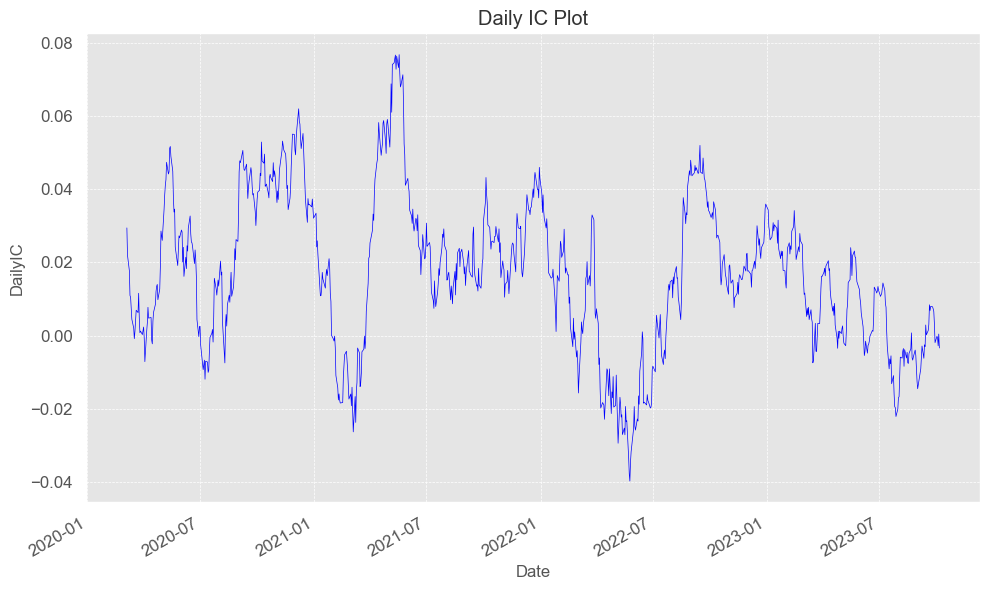

In [215]:
# Retrieves the indice for top 1 best performing SHARPE
max_sharpe_idx = max(keep, key=keep.get)
print(f'Best Sharpe Idx: {max_sharpe_idx}')
# Get model params from the "result" folder
best_model_params = get_max_ic_file(files.iloc[max_sharpe_idx], trial)
# Create a new dataframe of just predictions and actual returns
merged = price(best_model_params, dir_path, iteration=False, plot=True)

### Gain

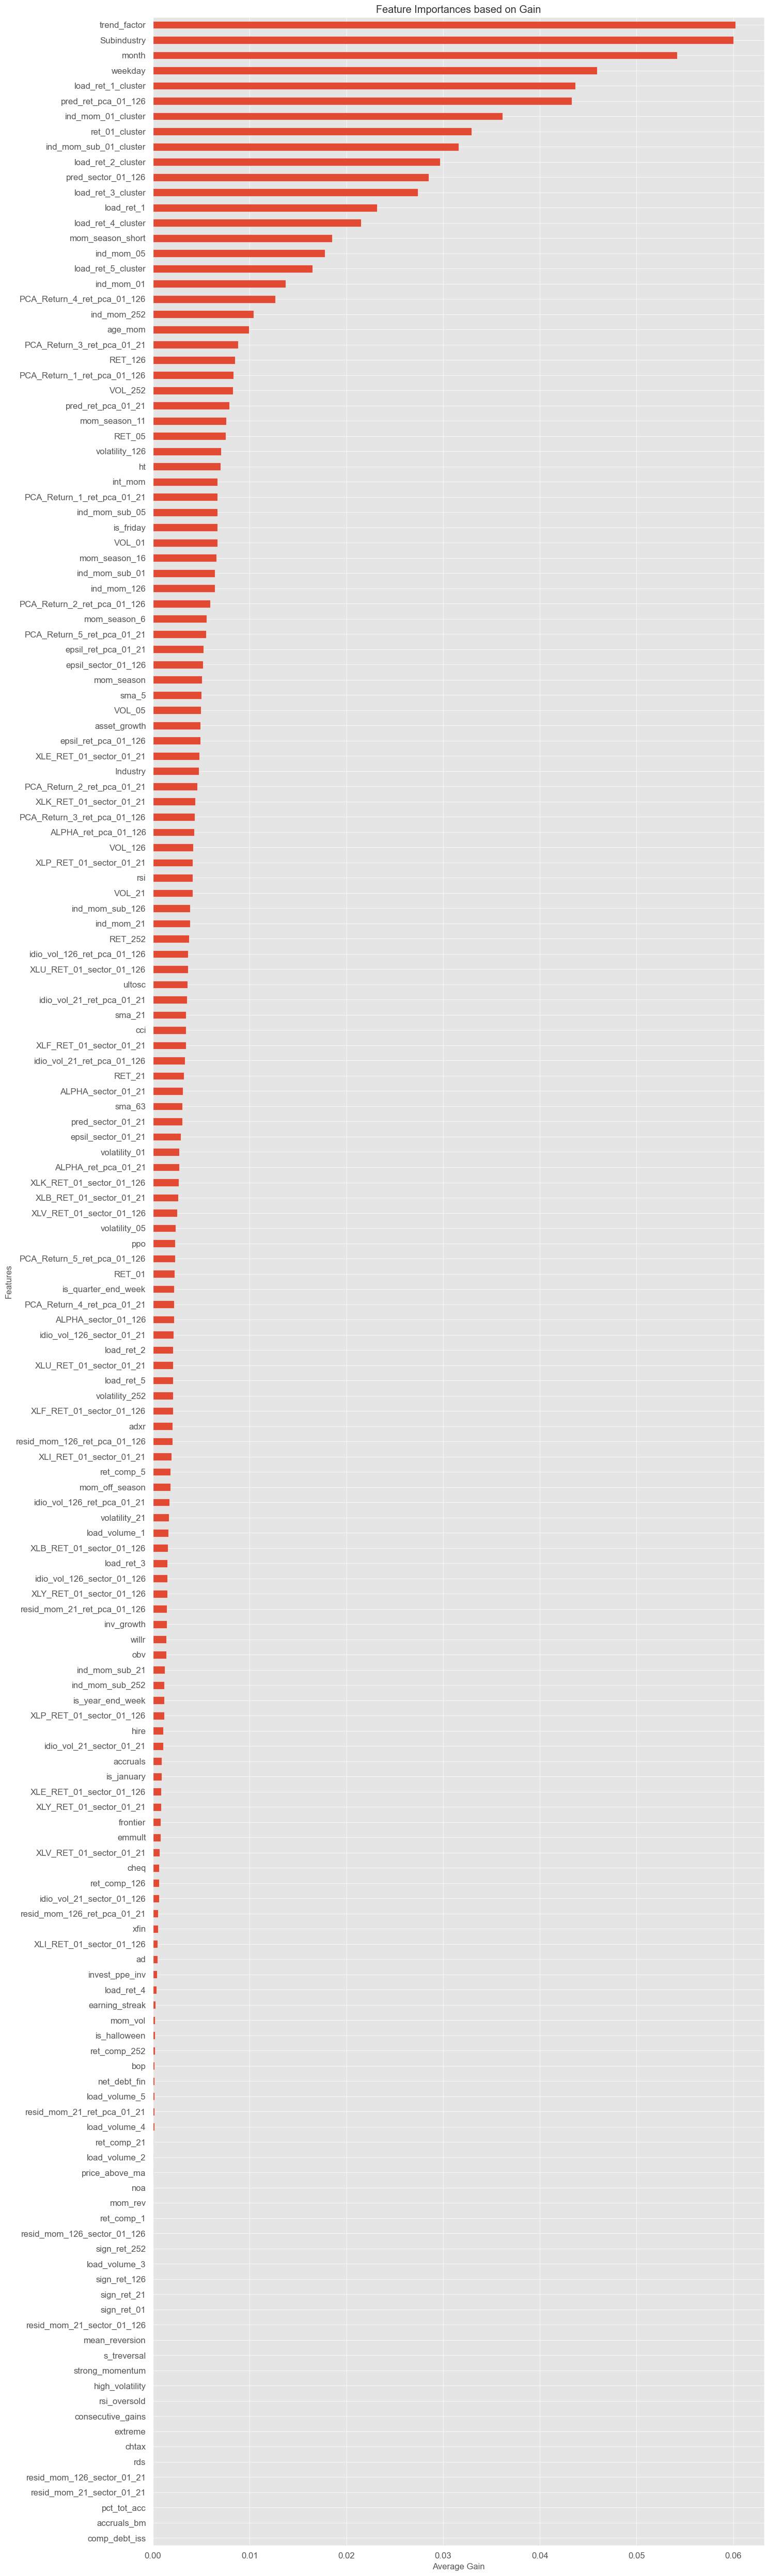

In [216]:
gain(best_model_params['gain'])

### Split

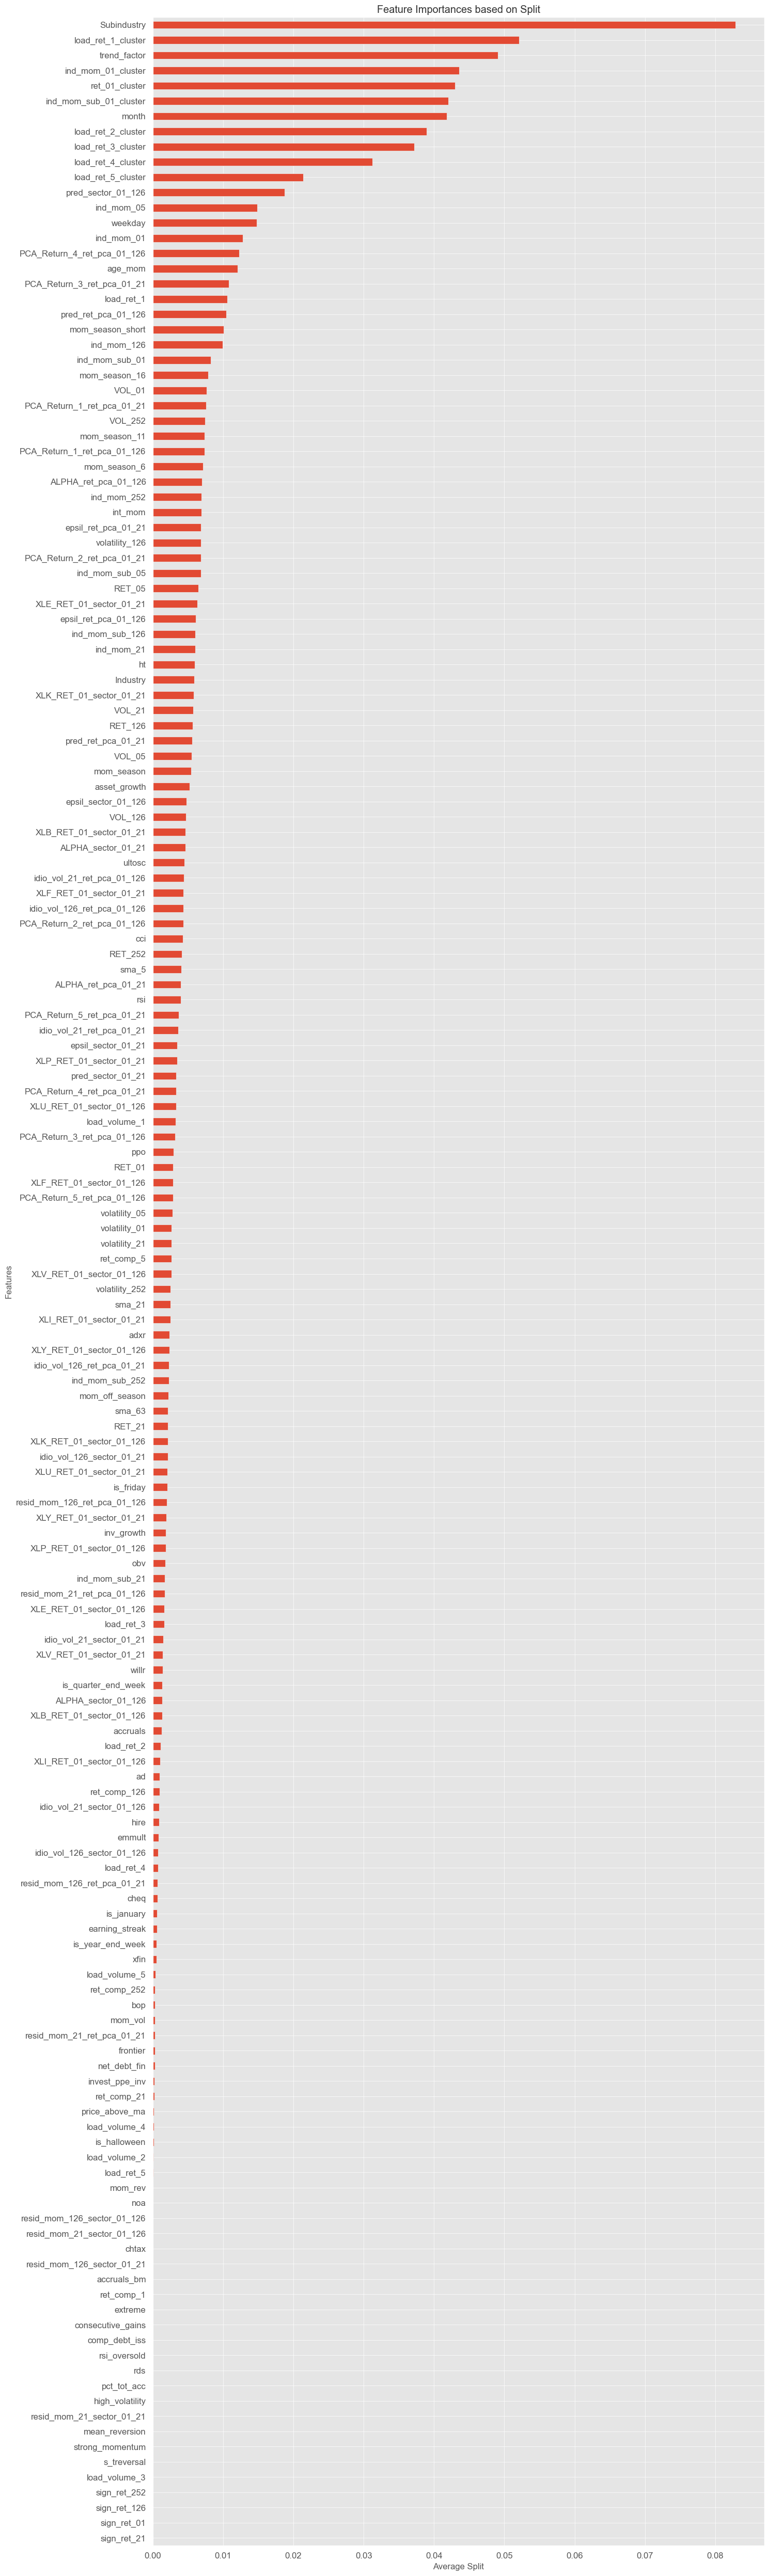

In [217]:
split(best_model_params['split'])

### Ensemble Predictions

Best Sharpe Idx: 0
Daily IC Mean: 0.01677


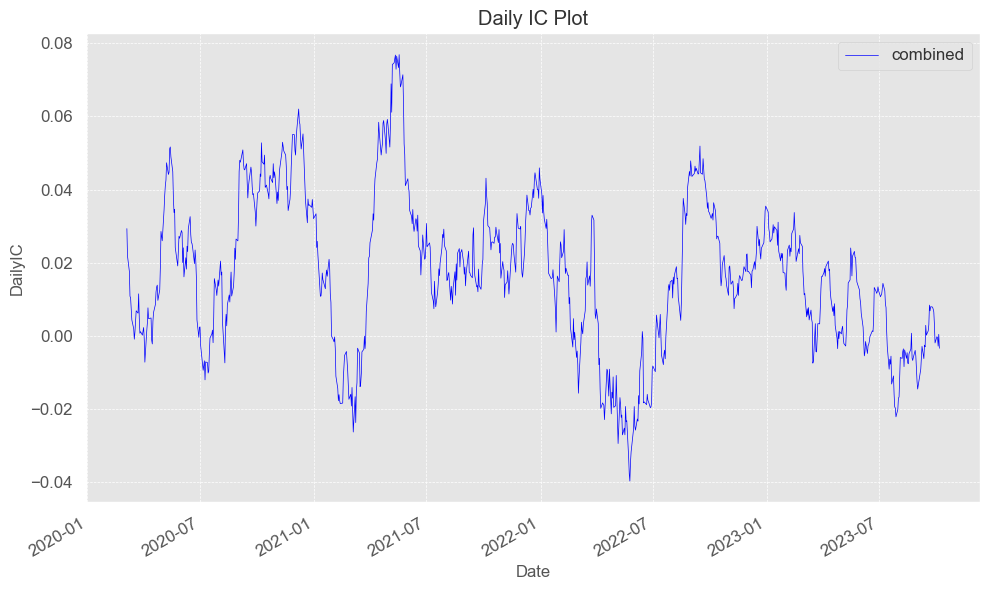

In [218]:
# Retrieves the indices from the top 5 best performing SHARPE
max_sharpe_idxs = sorted(keep, key=keep.get, reverse=True)[:5]
collect = []
# Append the individual trial predictions to a dataframe
for idx in max_sharpe_idxs:
    print(f'Best Sharpe Idx: {idx}')
    best_model_params = get_max_ic_file(files.iloc[idx], trial)
    merged = price(best_model_params, dir_path, iteration=False, plot=False)
    collect.append(merged['predictions'])

# Concat and calculate the mean of the predictions
total = pd.concat(collect, axis=1)
total['mean_predictions'] = total.mean(axis=1)
merged['predictions'] = total['mean_predictions']
# Calculate IC
by_day = merged.groupby(level='date')
ic_by_day = by_day.apply(lambda x: spearmanr(x.predictions, x.returns)[0]).to_frame('combined')
# Save Plot
plot_ensemble(merged, ic_by_day)

# Convert to Ticker

In [219]:
ticker = pd.read_parquet(get_parquet_dir(live) / 'data_ticker.parquet.brotli')
tic = merged.merge(ticker, left_index=True, right_index=True, how='left')
tic = tic.reset_index().set_index(['window', 'ticker', 'date'])
tic = tic.drop('permno', axis=1)

# Predicted vs. Actual

<AxesSubplot:xlabel='permno,date'>

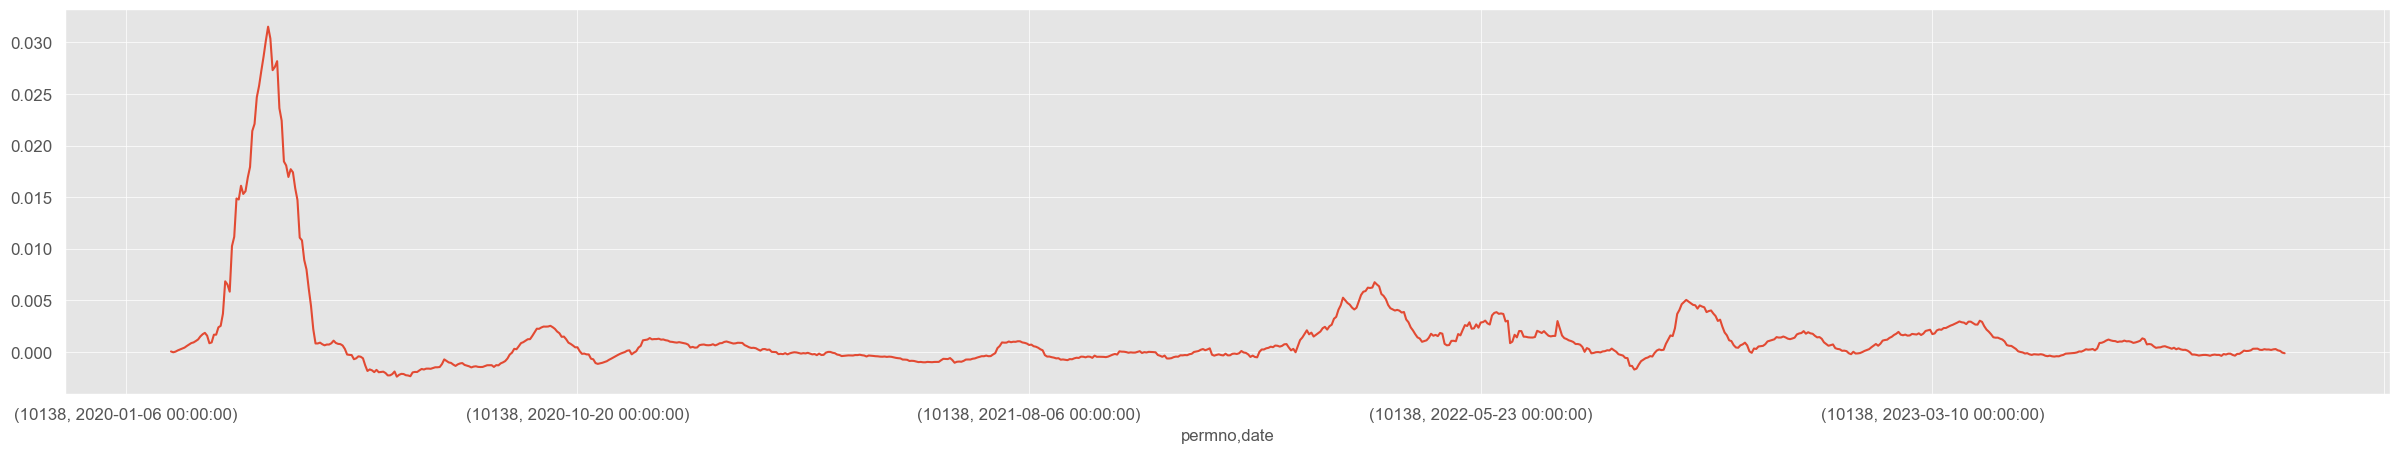

In [220]:
get_stock_data(merged, 10138).predictions.rolling(21).mean().plot(figsize=(30,5))

<AxesSubplot:xlabel='permno,date'>

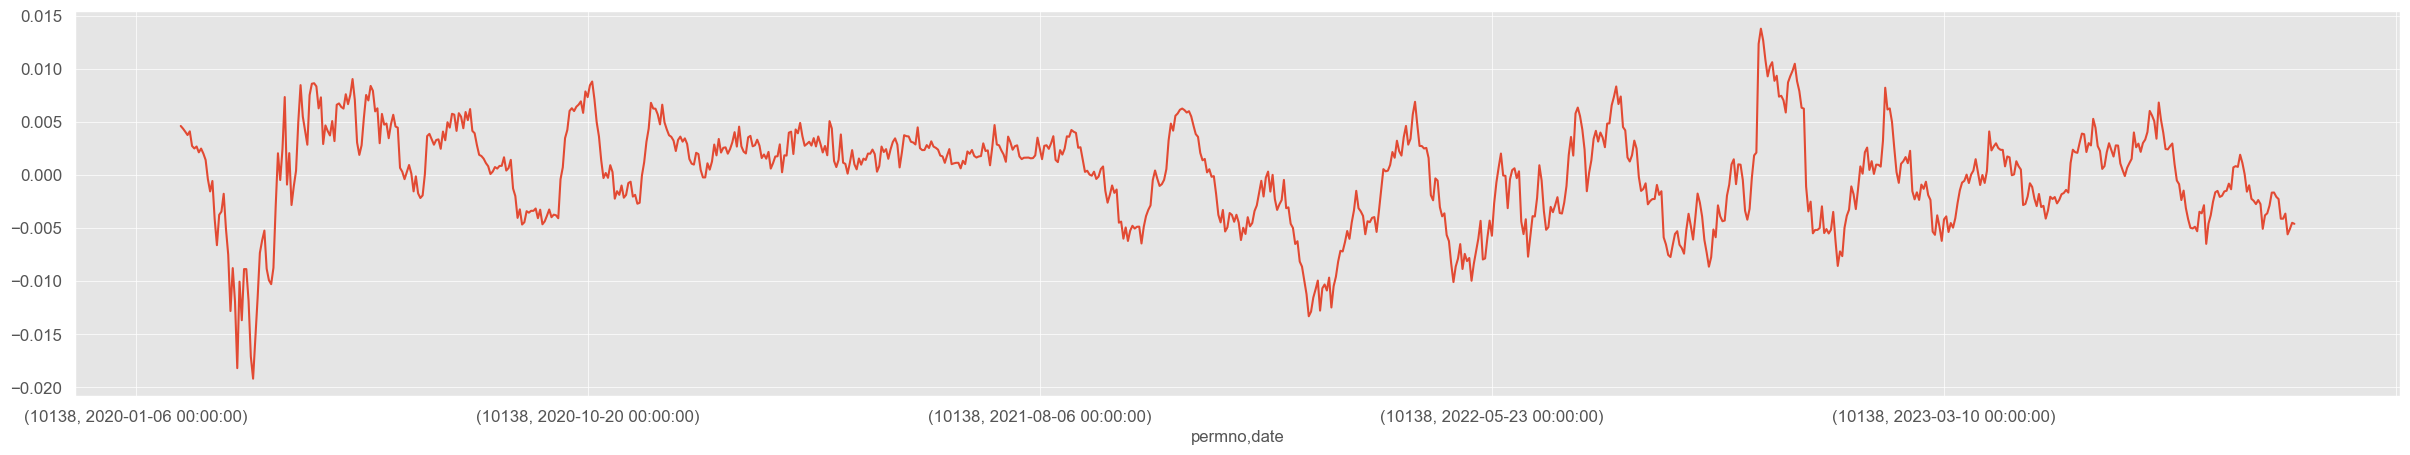

In [221]:
get_stock_data(merged, 10138).returns.rolling(21).mean().plot(figsize=(30, 5))

# Backtest

In [222]:
%%time
# Create the desired dataframe with structure longRet, longStocks, shortRet, shortStocks
pred_return = backtest(tic, num_stocks=50)

----------------------------------------------
2020
Num of tickers: 443
----------------------------------------------
2020
Num of tickers: 443
----------------------------------------------
2020
Num of tickers: 443
----------------------------------------------
2020
Num of tickers: 441
----------------------------------------------
2020
Num of tickers: 440
----------------------------------------------
2020
Num of tickers: 440
----------------------------------------------
2020
Num of tickers: 440
----------------------------------------------
2020
Num of tickers: 440
----------------------------------------------
2020
Num of tickers: 440
----------------------------------------------
2020
Num of tickers: 438
----------------------------------------------
2020
Num of tickers: 438
----------------------------------------------
2020
Num of tickers: 438
----------------------------------------------
2021
Num of tickers: 440
----------------------------------------------
2021
Num of ticke

# Portfolio Returns

### Long

In [223]:
#Get SPY returns (matching timeframe as our backtest)
spy_return = get_spy(start_date=pred_return.index[0]-timedelta(days=1), end_date=pred_return.index[-1]+timedelta(days=1))
spy = spy_return['spyRet']

[*********************100%%**********************]  1 of 1 completed


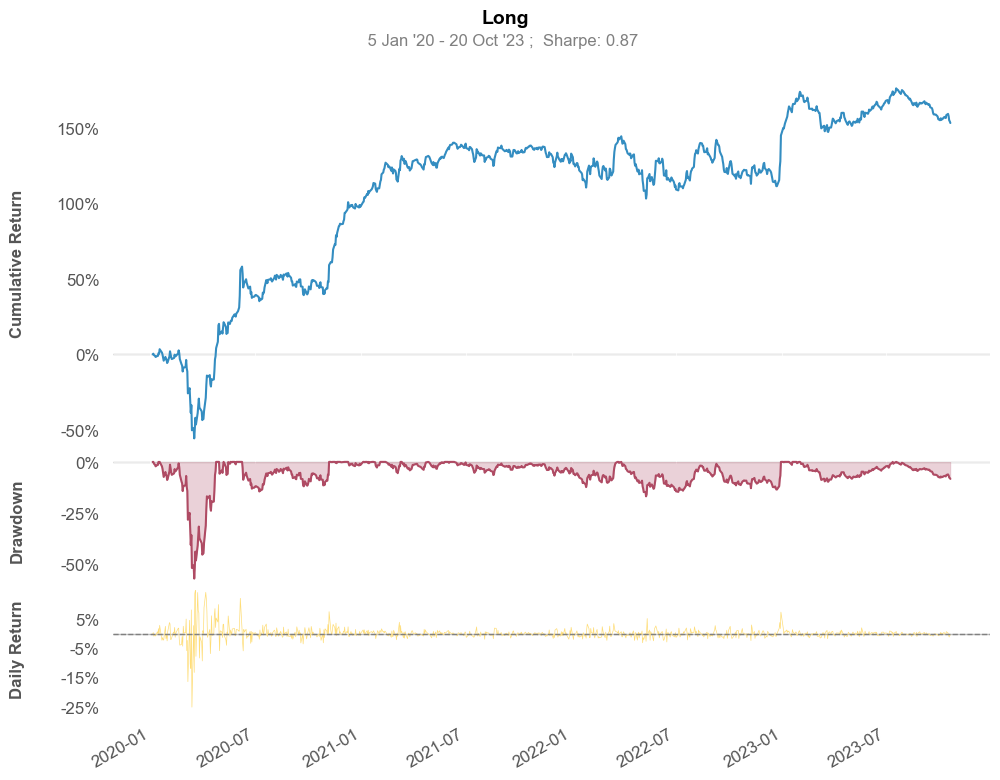

In [224]:
data = pred_return.copy(deep=True)
pred_return_opt = port_opt(data=data, window_size=21, port_opt_func=ewp, option='long', leverage=1)
long = pred_return_opt['totalRet']
qs.plots.snapshot(mode='basic', returns=long, benchmark=spy, title='Long', fig_size=(10, 10))

### Short

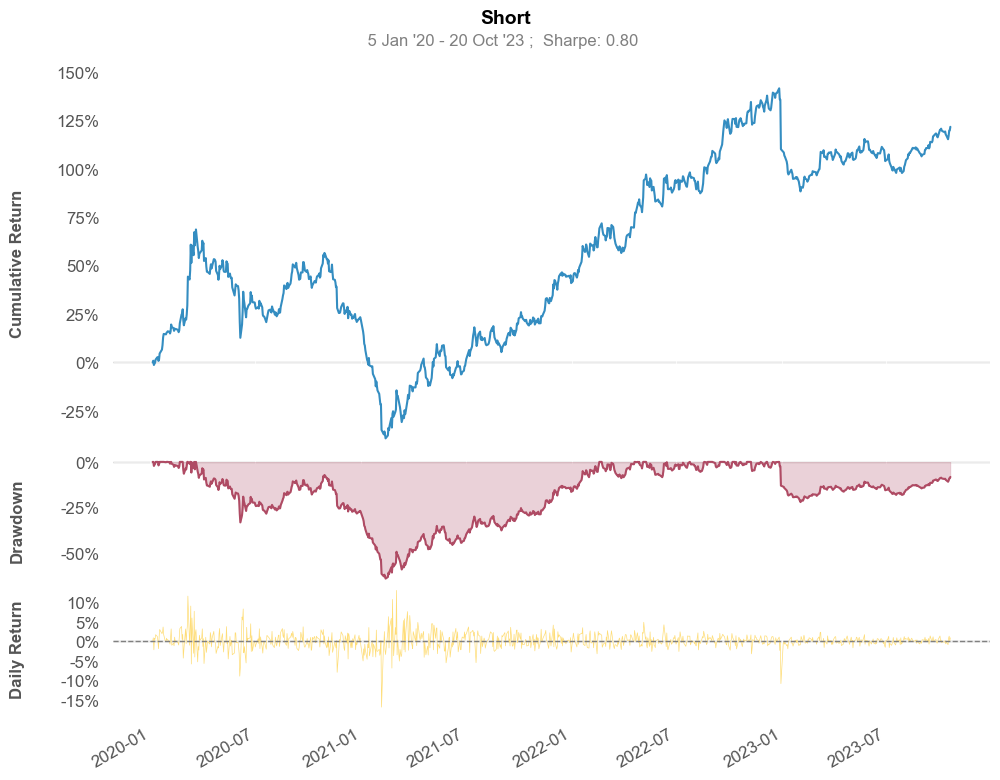

In [225]:
data = pred_return.copy(deep=True)
pred_return_opt = port_opt(data=data, window_size=21, port_opt_func=ewp, option='short', leverage=1)
short = pred_return_opt['totalRet']
# qs.reports.metrics(mode='basic', returns=stock, benchmark=spy, title='Short', fig_size=(10, 10))
qs.plots.snapshot(mode='basic', returns=short, benchmark=spy, title='Short', fig_size=(10, 10))

### Long and Short

In [226]:
data = pred_return.copy(deep=True)
pred_return_opt = port_opt(data=data, window_size=21, port_opt_func=ewp, option='both', leverage=1)
stock = pred_return_opt['totalRet']
# Save plot to "report" directory
qs.reports.html(stock, 'SPY', output=dir_path / 'report.html')

[*********************100%%**********************]  1 of 1 completed


# Stocks to Long and Short for the Next Day

In [229]:
long = pred_return.iloc[-1]['longStocks']
short = pred_return.iloc[-1]['shortStocks']

In [230]:
print("Stocks to long for tomorrow:\n")
n = len(long)
rows = int(math.sqrt(n))
cols = rows + (n - rows * rows) // rows
max_length = max([len(item) for item in long])
for i in range(0, n, cols):
    print(' | '.join([item.ljust(max_length) for item in long[i:i+cols]]))

Stocks to long for tomorrow:

AKAM | SJM  | CTAS | TSM  | MDLZ | MNST | KHC 
TRV  | AEZS | ST   | HUBS | DVN  | ACHV | AME 
FCX  | TV   | SLRX | SMLP | Z    | BXP  | CBRE
DISH | ARE  | PLD  | VNO  | CENN | GPC  | AGNC
SLG  | CIM  | MFA  | ILMN | NLY  | MDGL | CYTO
IVR  | JD   | NURO | LKQ  | TWO  | IMUX | ONTX
QLGN | CBIO | SNES | DOMH | SEEL | YTEN | RSLS
BXRX


In [231]:
print("Stocks to long for tomorrow:\n")
n = len(short)
rows = int(math.sqrt(n))
cols = rows + (n - rows * rows) // rows
max_length = max([len(item) for item in short])
for i in range(0, n, cols):
    print(' | '.join([item.ljust(max_length) for item in short[i:i+cols]]))

Stocks to long for tomorrow:

BPTH | TANH | TNXP | LUMN | VIRX | TBLT | SHIP
FWBI | ONCT | NRBO | PALI | HSTO | AYRO | VXRT
SOS  | ANY  | FCEL | CVNA | FRTX | KA   | FTCH
RNG  | CYCC | SLS  | W    | IEP  | NWL  | ATUS
GRPN | ENOV | MBOT | KALA | GLBS | PARA | OCN 
SIRI | AIM  | RIOT | SLB  | ELDN | FMC  | NTAP
BGNE | ROST | TDW  | MMM  | NVR  | EGO  | NBY 
ESTC


In [232]:
def print_rectangle(stocks, title):
    n = len(stocks)
    cols = int(math.sqrt(2 * n))
    rows = n // cols + (n % cols > 0)
    max_length = max([len(item) for item in stocks])

    html_content = f"<h3>{title}</h3><table style='font-size: 11px;'><tr>"
    for i in range(n):
        html_content += f"<td style='padding: 8px; border: 1.5px solid; text-align: center;'>{stocks[i]}</td>"
        if (i + 1) % cols == 0:
            html_content += "</tr><tr>"
    html_content += "</tr></table>"
    return html_content

# Use display to show them side by side
content = "<div style='float: left; width: 50%;'>" + print_rectangle(long, "Stocks to Long Tomorrow:") + "</div>"
content += "<div style='float: left; width: 50%;'>" + print_rectangle(short, "Stocks to Short Tomorrow:") + "</div>"

display(HTML(content))

AKAM,SJM,CTAS,TSM,MDLZ,MNST,KHC,TRV,AEZS,ST
HUBS,DVN,ACHV,AME,FCX,TV,SLRX,SMLP,Z,BXP
CBRE,DISH,ARE,PLD,VNO,CENN,GPC,AGNC,SLG,CIM
MFA,ILMN,NLY,MDGL,CYTO,IVR,JD,NURO,LKQ,TWO
IMUX,ONTX,QLGN,CBIO,SNES,DOMH,SEEL,YTEN,RSLS,BXRX
BPTH,TANH,TNXP,LUMN,VIRX,TBLT,SHIP,FWBI,ONCT,NRBO
PALI,HSTO,AYRO,VXRT,SOS,ANY,FCEL,CVNA,FRTX,KA
FTCH,RNG,CYCC,SLS,W,IEP,NWL,ATUS,GRPN,ENOV
MBOT,KALA,GLBS,PARA,OCN,SIRI,AIM,RIOT,SLB,ELDN
FMC,NTAP,BGNE,ROST,TDW,MMM,NVR,EGO,NBY,ESTC
